In [1]:
# modules call
from skimage.filters import threshold_local
import imutils
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytesseract
from gtts import gTTS
import os

In [2]:
# custom functions
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([[0, 0], [maxWidth - 1, 0], [maxWidth - 1, maxHeight - 1], [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

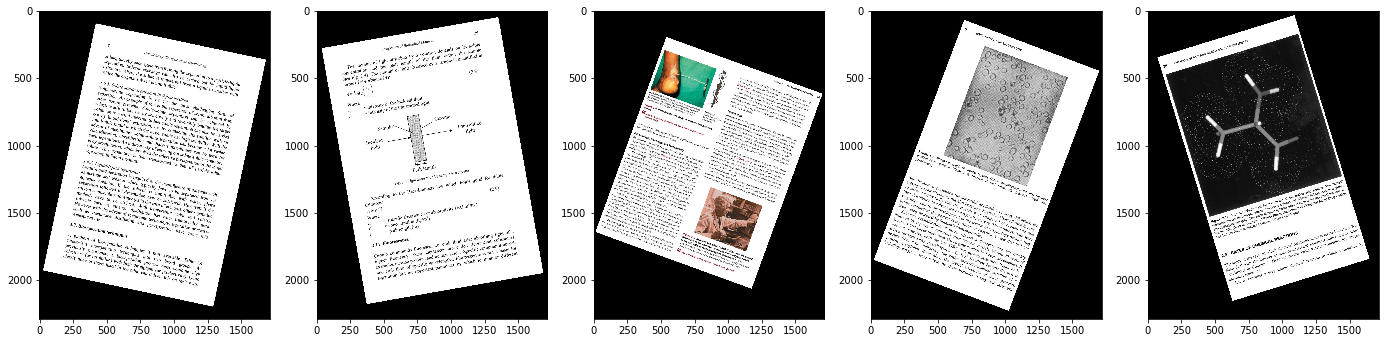

In [3]:
plt.figure(figsize=[24, 24])
for i in range(1,6):
    plt.subplot(int("15{}".format(i)))
    plt.imshow(plt.imread("ostDataset/{}.jpg".format(i)))

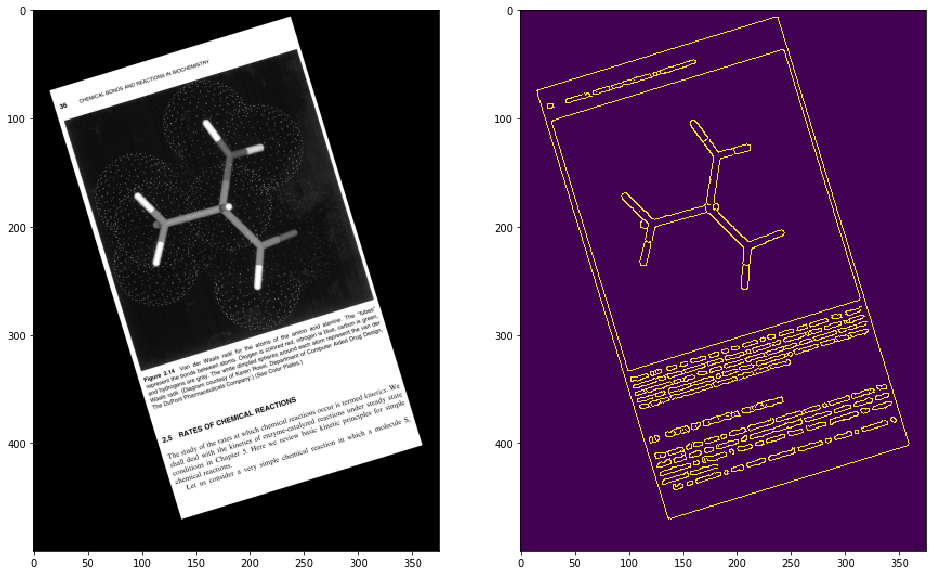

In [4]:
# load the image and compute the ratio of the old height
# to the new height, clone it, and resize it
image = plt.imread("ostDataset/5.jpg")
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height = 500)

# convert the image to grayscale, blur it, and find edges
# in the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 75, 200)

plt.figure(figsize=[16,16])
plt.subplot(int("121".format(i)))
plt.imshow(image)
plt.subplot(int("122".format(i)))
plt.imshow(edged)

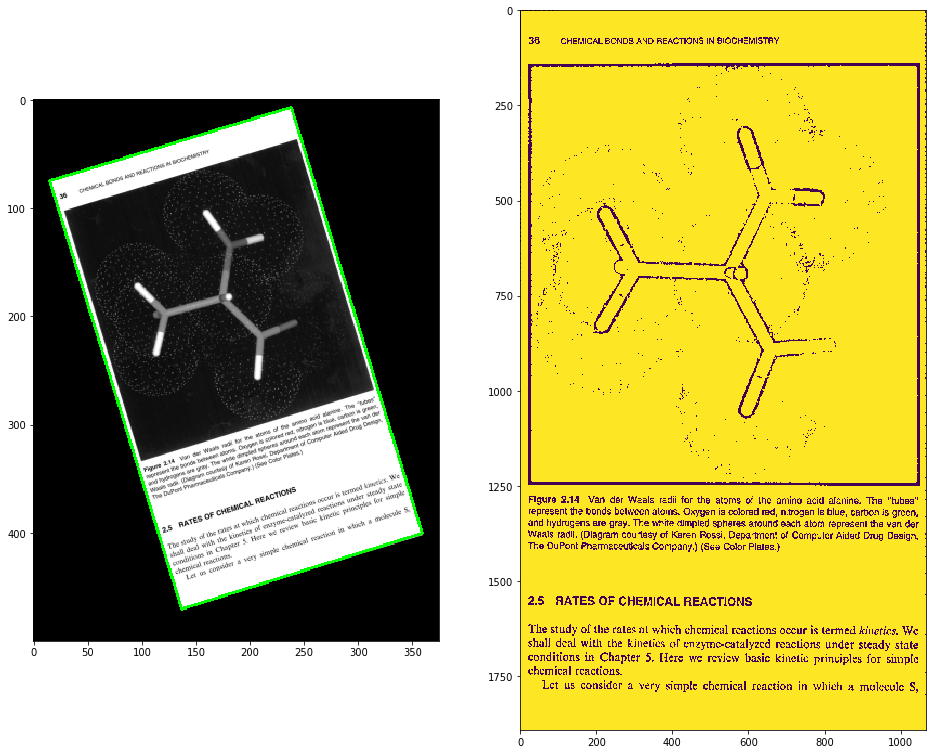

In [5]:
# find the contours in the edged image, keeping only the
# largest ones, and initialize the screen contour
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
screenCnt =[]
# loop over the contours
for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, .02 * peri, True)
    
    # if our approximated contour has four points, then we
    # can assume that we have found our screen
    if len(approx) == 4:
        screenCnt = approx
        break

# show the contour (outline) of the piece of paper
# print("STEP 2: Find contours of paper")
plt.figure(figsize=[16,16])
if screenCnt.any():
    image = cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
    plt.subplot(int("121".format(i)))
    plt.imshow(image)
    # apply the four point transform to obtain a top-down
    # view of the original image
    warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)

    # convert the warped image to grayscale, then threshold it
    # to give it that 'black and white' paper effect
    warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    T = threshold_local(warped, 31, offset = 15, method = "gaussian")
    warped = (warped > T).astype("uint8") * 255

    # show the original and scanned images
    # print("STEP 3: Apply perspective transform")
    # cv2.imshow("Original", imutils.resize(orig, height = 650))
    # cv2.imshow("Scanned", imutils.resize(warped, height = 650))
    plt.subplot(int("122".format(i)))
    plt.imshow(warped)
else: 
    print("no contours found, no reshape needed")

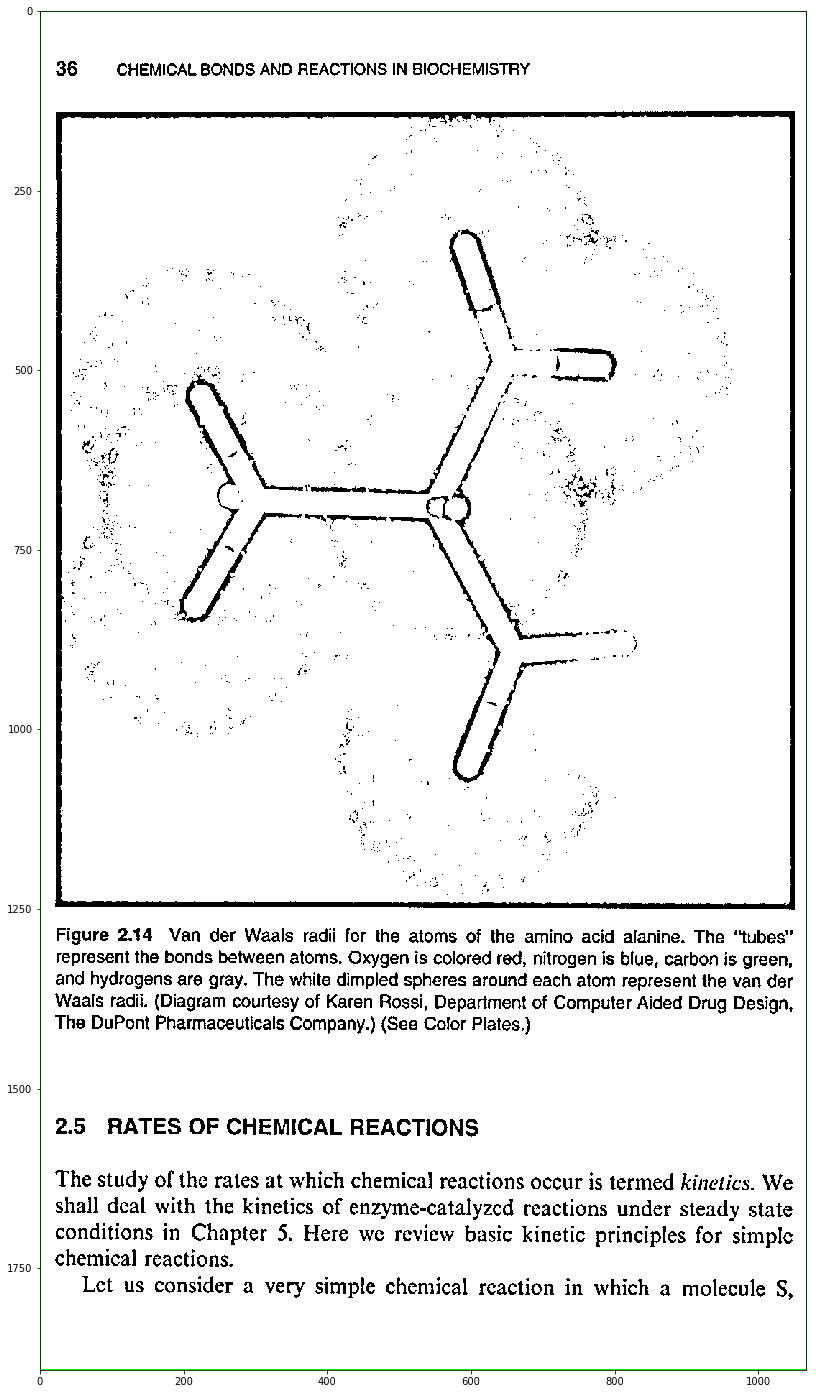

In [6]:
neg = cv2.bitwise_not(warped)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 15))
dilate = cv2.morphologyEx(neg, cv2.MORPH_DILATE, kernel)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 15))
connected = cv2.morphologyEx(dilate, cv2.MORPH_CLOSE, kernel, iterations=2)

vis = cv2.cvtColor(warped,cv2.COLOR_GRAY2RGB)
contours, hierarchy = cv2.findContours(connected, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
boxes = map(lambda c: cv2.boundingRect(c), contours)
filtered = filter(lambda b: b[2] > 30 and b[3] > 45, boxes)

for (x, y, w, h) in filtered:
    cv2.rectangle(vis, (x, y), (x+w-1, y+h-1), (0, 255, 0), 2)

plt.figure(figsize=(25, 25))
plt.imshow(vis)

In [7]:
text = pytesseract.image_to_string(warped).replace("\n", "");
text = text.split('. ')
print(text)

['36 CHEMICAL BONDS AND REACTIONS IN BIOCHEMISTRY Figure 2.14 Van der Waals radii for the atoms of the amino acid alanine', 'The “tubes"represent the bonds between atoms', 'Oxygen is colored red, nitrogen is blue, carbon is green,and hydrogens are gray', 'The white dimpled spheres around each atom represent the van derWaals radii', '(Diagram counesy of Karen Rossi, Department of Computer Aided Drug Design,The DuPont Pharmaceuticals Company.) (See Color Plates.)2.5 RATES OF CHEMICAL REACTIONSThe study of the rates at which chemical reactions occur is termed kinetics', 'Weshall deal with the kinetics of enzyme-catalyzed reactions under steady stateconditions in Chapter 5', 'Here we review basic kinetic principles for simplechemical reactions.Let us consider a very simple chemical reaction in which a molecule S,']


In [8]:
for line in text:
    if line != '':
        tts = gTTS(text=repr(line), lang='en')
        tts.save("text.mp3")
        os.system("mpg123 text.mp3")
        os.system("rm text.mp3")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-878f217cf1d7>", line 3, in <module>
    tts = gTTS(text=repr(line), lang='en')
  File "/home/lorforlinux/.local/lib/python3.7/site-packages/gtts/tts.py", line 119, in __init__
    langs = tts_langs()
  File "/home/lorforlinux/.local/lib/python3.7/site-packages/gtts/lang.py", line 36, in tts_langs
    langs.update(_fetch_langs())
  File "/home/lorforlinux/.local/lib/python3.7/site-packages/gtts/lang.py", line 56, in _fetch_langs
    page = requests.get(URL_BASE)
  File "/usr/lib/python3.7/site-packages/requests/api.py", line 75, in get
    return request('get', url, params=params, **kwargs)
  File "/usr/lib/python3.7/site-packages/requests/api.py", line 60, in request
    return session.request(method=method, url=url, **kwargs)
  File "/usr/lib/python3.7/site-packages/requests/

KeyboardInterrupt: 